In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-15-dbf369a8b2a8>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


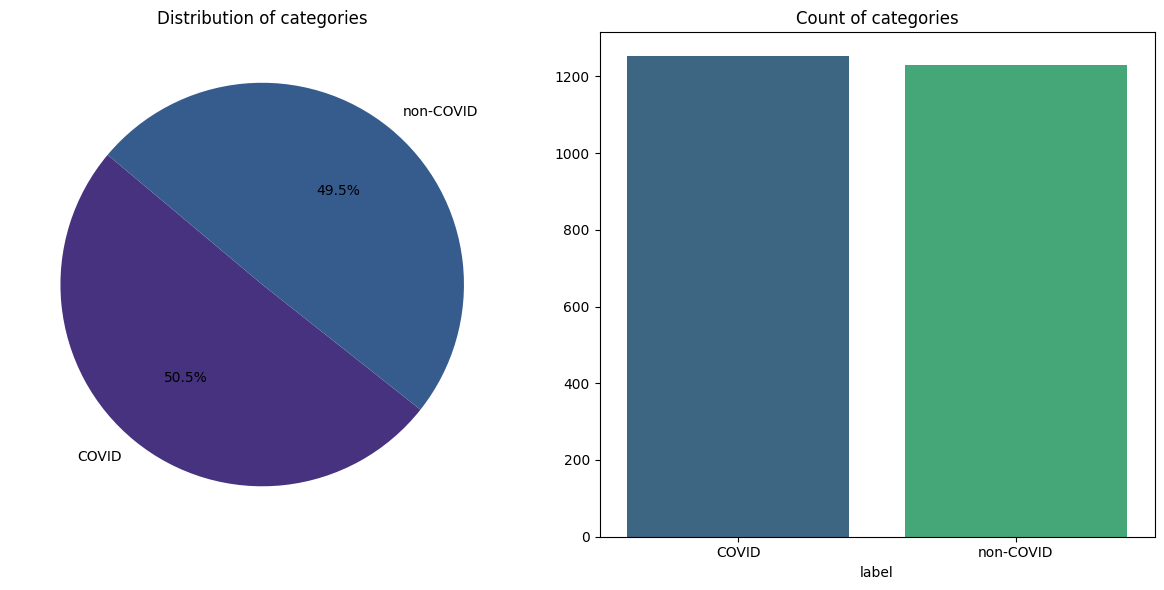

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# directory containing the "Train" folder
directory = "/content/drive/MyDrive/sars_covid_archive"

# initialize lists for storing file paths and labels
filepaths = []
labels = []

# iterate over each folder (category) in the directory
for fold in os.listdir(directory):
    fold_path = os.path.join(directory, fold)
    filepaths.extend(os.path.join(fold_path, img) for img in os.listdir(fold_path))
    # extend labels list with repeated folder name
    labels.extend([fold] * len(os.listdir(fold_path)))

# create DataFrame directly from the lists
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# get counts of each label
count = df['label'].value_counts()

# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of categories')

# plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of categories')

# adjust layout and display the plot
plt.tight_layout()
plt.show()


In [16]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

def create_splits(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.15):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    files = os.listdir(source_dir)
    np.random.shuffle(files)

    n_train = int(len(files) * train_size)
    n_val = int(len(files) * val_size)

    for i, file in enumerate(files):
        if i < n_train:
            shutil.copy(os.path.join(source_dir, file), train_dir)
        elif i < n_train + n_val:
            shutil.copy(os.path.join(source_dir, file), val_dir)
        else:
            shutil.copy(os.path.join(source_dir, file), test_dir)

# create the splits for COVID and non-COVID datasets
create_splits('/content/drive/MyDrive/sars_covid_archive/COVID', 'data/train/COVID', 'data/val/COVID', 'data/test/COVID')
create_splits('/content/drive/MyDrive/sars_covid_archive/non-COVID', 'data/train/non-COVID', 'data/val/non-COVID', 'data/test/non-COVID')

In [17]:
# function to prepare datasets using TensorFlow's utilities
def prepare_dataset(directory, subset, seed=123, image_size=(256, 256), batch_size=32, validation_split=None):
    return keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size)

In [18]:
IMAGE_SIZE = (256, 256)

print('Training dataset:')
train_ds = prepare_dataset('data/train', 'training', validation_split=0.1)

print('Validation dataset:')
validation_ds = prepare_dataset('data/val', 'validation', validation_split=0.1)

print('Test dataset:')
test_ds = prepare_dataset('data/test', None)

Training dataset:
Found 2258 files belonging to 2 classes.
Using 2033 files for training.
Validation dataset:
Found 680 files belonging to 2 classes.
Using 68 files for validation.
Test dataset:
Found 699 files belonging to 2 classes.


In [19]:
# extract labels and encode them
def encode_labels(dataset):
    label_encoder = LabelEncoder()
    label_encoder.fit(['non-COVID', 'COVID'])
    return label_encoder.transform(dataset.class_names)

train_labels_encoded = encode_labels(train_ds)
validation_labels_encoded = encode_labels(validation_ds)
test_labels_encoded = encode_labels(test_ds)

In [20]:
import tensorflow as tf

# normalize the images
def normalize_images(image, label):
    return image / 255.0, label

train_ds = train_ds.map(normalize_images)
validation_ds = validation_ds.map(normalize_images)
test_ds = test_ds.map(normalize_images)

In [21]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import random

def visualize_images(path, num_images):
    # to filter for image files only, assuming common image formats
    image_filenames = glob(os.path.join(path, '*.[pP][nN][gG]')) + glob(os.path.join(path, '*.[jJ][pP][gG]'))

    # if no images are found, return an appropriate message
    if not image_filenames:
        print("No image files found in the directory.")
        return

    # shuffle and select a subset of image filenames
    random.shuffle(image_filenames)
    image_filenames = image_filenames[:num_images]

    # determine the number of images and adjust subplot accordingly
    num_images = len(image_filenames)
    if num_images == 0:
        print("No images to display.")
        return

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3), facecolor='white')

    # check if there's only one image to avoid indexing error
    if num_images == 1:
        axes = [axes]

    for ax, image_filename in zip(axes, image_filenames):
        image = mpimg.imread(image_filename)
        ax.imshow(image)
        ax.axis('off')  # hide axes
        ax.set_title(os.path.basename(image_filename))

    plt.tight_layout()
    plt.show()


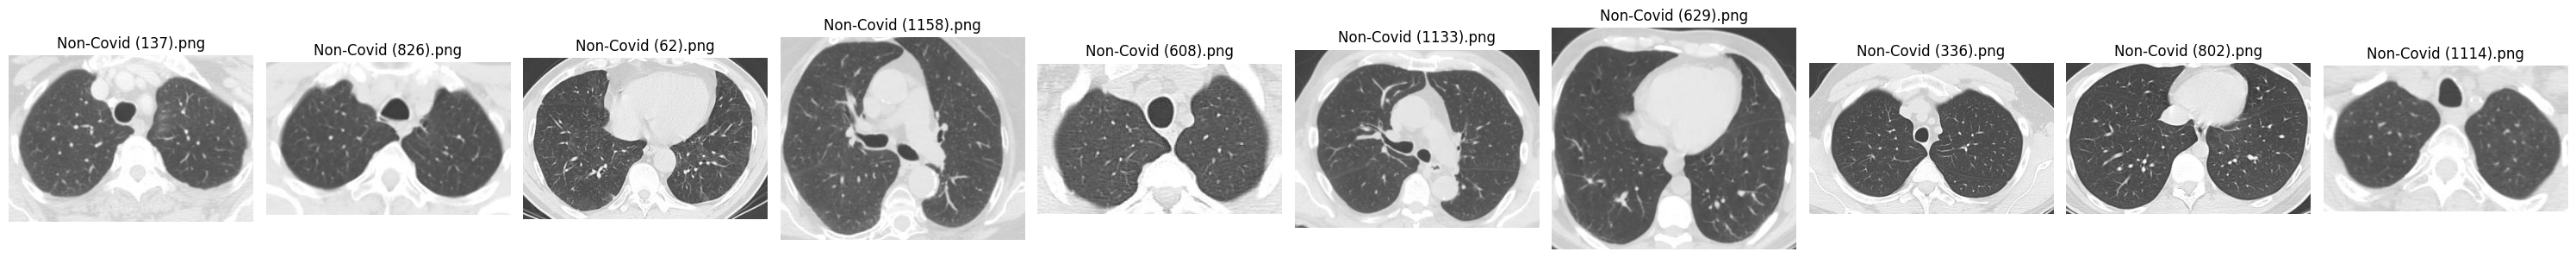

In [22]:
visualize_images('data/train/non-COVID', 10)

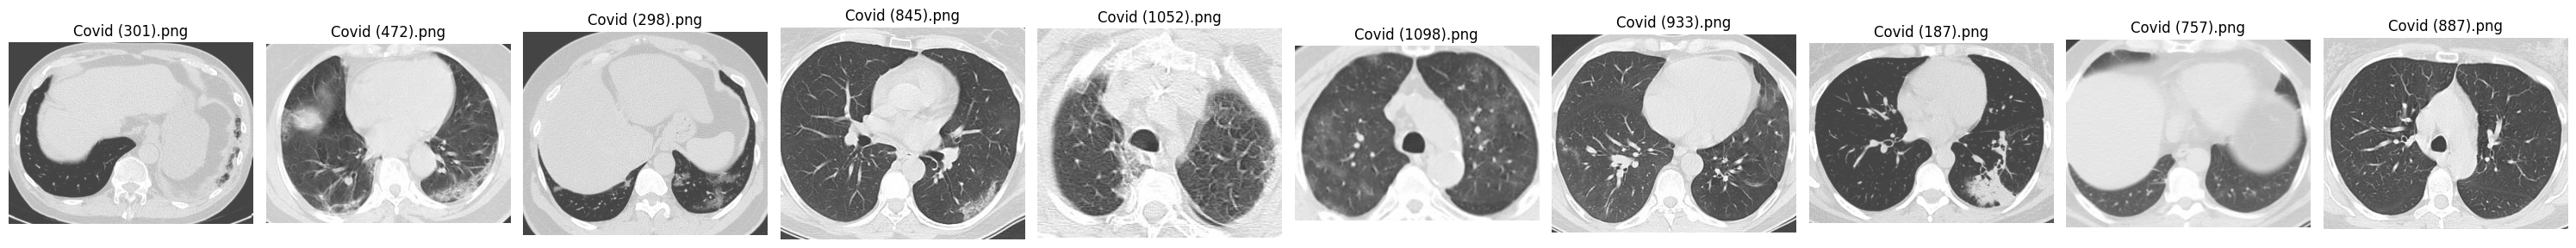

In [23]:
visualize_images('data/train/COVID', 10)

In [24]:
!mkdir callback

mkdir: cannot create directory ‘callback’: File exists


In [25]:
!ls

callback  data	drive  sample_data


# Deep learning model: binary classification with Xception

Outlines the structure and functionality of a binary classification deep learning model built using the Xception architecture and implemented in Keras. The model is designed to distinguish between two classes (e.g., "positive" and "negative") based on input images.

## Model architecture

The model leverages the Xception architecture, a deep convolutional neural network designed by Google. Xception stands for "Extreme Inception," which modifies the original Inception architecture by replacing Inception modules with depthwise separable convolutions.

### Components of the model

1. **Base model (Xception)**
   - **Configuration:** `weights='imagenet', include_top=False, pooling='avg'`
   - The Xception model pre-trained on the ImageNet dataset is used as the feature extractor. The top classification layer is omitted (`include_top=False`), and global average pooling is applied to the output of the last convolutional layer (`pooling='avg'`).

2. **Batch normalization**
   - Normalizes the activations of the previous layer at each batch, i.e., applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

3. **Dropout layers**
   - First dropout ratio: `0.45`
   - Second dropout ratio: `0.25`
   - Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This prevents overfitting.

4. **Dense layers**
   - First dense layer with 220 neurons, ReLU activation.
   - Second dense layer with 60 neurons, ReLU activation.
   - The Dense layer is a deeply connected layer where each input node is connected to each output node.

5. **Output layer**
   - Single neuron with sigmoid activation function for binary classification.

### Mathematical formulation

The model uses the sigmoid activation function in the output layer, defined as:

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

This function outputs a value between 0 and 1, which is interpreted as the probability of the input being in the class "positive."

### Model compilation

- **Optimizer:** Adamax with a learning rate of 0.001.
- **Loss Function:** Binary crossentropy, defined as:

$$ \text{Binary Crossentropy} = -\frac{1}{N} \sum_{i=1}^N [y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i})] $$

Where 𝑦𝑖 is the true label, and (\hat{y_i}) is the predicted probability.

- **Metrics:** accuracy.

## Training

The model is trained using the following strategies:

- **Early Stopping:** Monitor `val_loss` with a patience of 5 epochs.
- **Reduce Learning Rate on Plateau:** Factor of 0.2, patience of 3, and a minimum learning rate of 0.00001.
- **Model Checkpointing:** Save the best model based on `val_accuracy`.

### Tqdm callback

This callback integrates with Tqdm to display nice, visual progress bars during training.

## Conclusion

This model uses advanced techniques in image processing and neural networks to perform binary classification. Its architecture leverages the proven capabilities of the Xception model, enhanced with dropout for regularization, and dense layers for classification. The training process is carefully managed to optimize performance and prevent overfitting, aiming for the highest accuracy in classifying new, unseen images.


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adamax
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import Xception
from tqdm.keras import TqdmCallback

def build_model(input_shape=(256, 256, 3)):
    base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)

    # freeze the layers of the base model to prevent them from being updated during training.
    base_model.trainable = False

    # build the model architecture
    # layer's output serves as the input to the next layer.
    model = Sequential([
        base_model, # the base model as the first layer.
        BatchNormalization(), # normalize the activations from the previous layer, improving training stability.
        Dropout(0.45), # randomly set about 45% of input units to 0 at each update during training time, which helps prevent overfitting.
        Dense(220, activation='relu'), # dense layer with 220 neurons and ReLU activation function, introduces non-linearity and learning capabilities.
        Dropout(0.25), # another dropout for regularization, but with a lower rate of 25%.
        Dense(60, activation='relu'), # an additional Dense layer with 60 neurons and ReLU activation, adds depth to the model.
        Dense(1, activation='sigmoid') # output layer with one neuron and sigmoid activation, provides binary classification outputs.
    ])

    # compile the model, setting the optimizer, loss function, and metrics for training.
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# instantiate the model
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_9 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 220)               450780    
                                                                 
 dropout_3 (Dropout)         (None, 220)               0         
                                                                 
 dense_4 (Dense)             (None, 60)                13260     
                                                      

In [27]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('callback/best_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
tqdm_callback = TqdmCallback(verbose=1)

# fit the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds,
    verbose=0,
    callbacks=[early_stopping, reduce_lr, checkpoint, tqdm_callback]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

22/22 [==============================] - 8s 251ms/step - loss: 0.0660 - accuracy: 0.9771
Test Loss: 0.06603682041168213
Test Accuracy: 0.9771101474761963


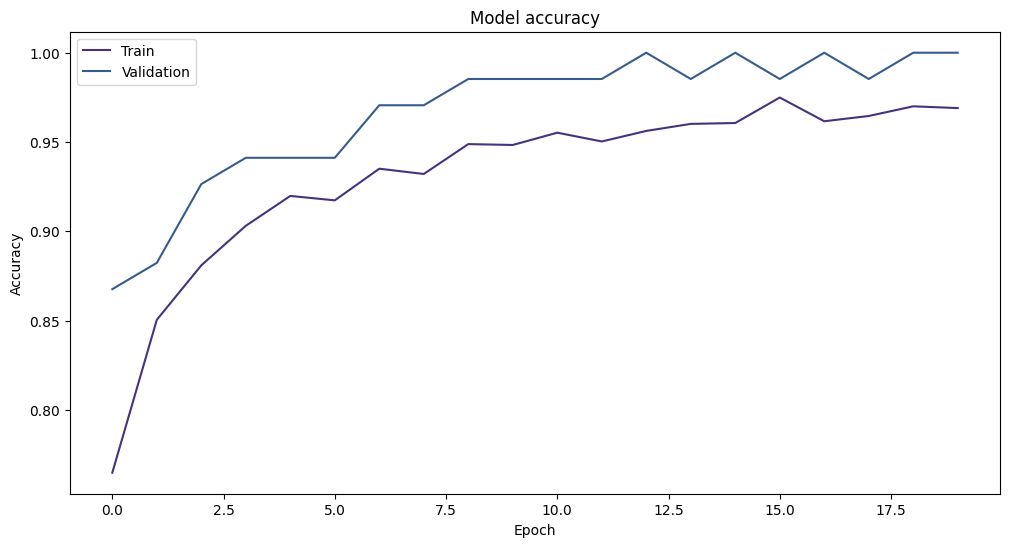

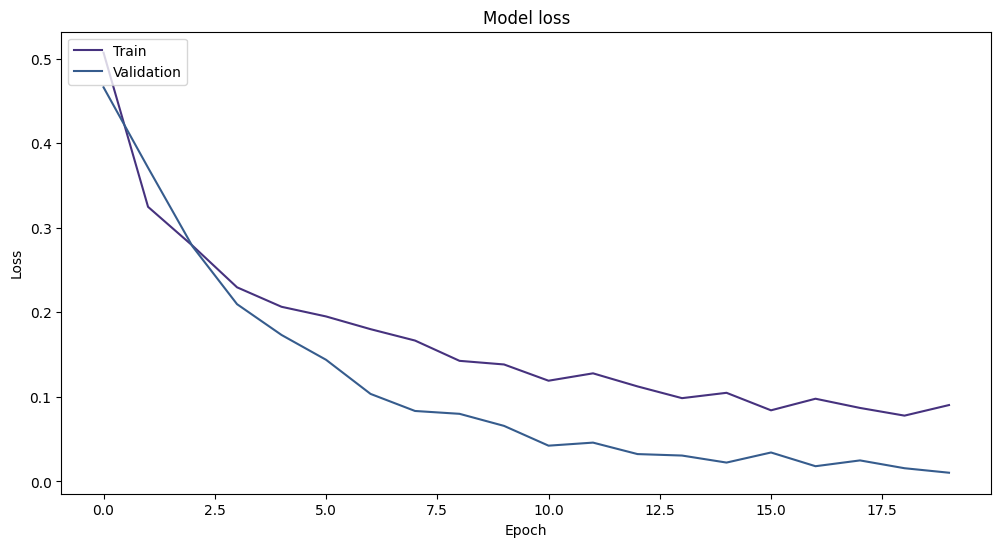

In [29]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()